# Borehole rock-physics
## Investigating the accuracy of various rock-physics transforms using borehole data

In [454]:
from pathlib import Path
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
import lasio
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
sns.set(color_codes=True)

In [455]:
workdir = Path('../')
lasdir = workdir.joinpath('data','las_MPWSP')
auxdir=  workdir.joinpath('data','auxiliary')
figdir=  workdir.joinpath('work','figs')

### Create common masks and functions

In [895]:
def mask_nonan(df,nan_col_list):
    mask = df.notnull()
    return mask.loc[:,nan_col_list].all(axis=1)

def mask_noclay(df,nan_col_list):
    return ~df.loc[mask_nonan(df,nan_col_list),'lith'].str.contains("C")

def mask_SP_only(df,nan_col_list):
    return df.loc[mask_nonan(df,nan_col_list),'lith']=="SP"

def mask_stds(df,nstds,testcol,nan_col_list):
    pop = df.loc[mask_nonan(df,nan_col_list),testcol]
    return  np.logical_and(pop < np.mean(pop)+nstds*np.std(pop),
                           pop > np.mean(pop)-nstds*np.std(pop))
def mask_wherescreen(df,nan_col_list):
    return  mask_nonan(df[df.screen.notnull()],nan_cols)

def tds2rho_est(tds,m=.692826,b=-220.28):
    return 1e4*m/(tds-b)

def rho2tds_est(rho,m=.692826,b=-220.28):
    return 1e4*m/rho + b

def cond2rho(cond):
    return 1e4/cond
    
def nested_logicals(df,list_of_conditions,func=np.logical_and):
    '''
    Convenience function to nest numpy logical functions
        Input: 
            df
            list_of_conditions
            func: numpy function to be applied
        Output:
            logical mask for the given dataframe
        '''
    out = np.ones(len(list_of_conditions[0]),dtype=bool)
    for i in range(len(list_of_conditions)):
        out = func(out,list_of_conditions[i])
    return out

def interpIntervals(df,interp_cols,group_cols=['Well','Year'],dept_col='DEPT',interval=.5):
    '''
    Interpolates numerical values to a specified resolution (interval) 
    Meant for use with depth-registered well data
        Input:
            df: DataFrame
            interp_cols: list
            group_cols: list
            dept_col: str
            interval: numeric
        Output:
            DataFrame with interpolated rows
    '''
    frames = []
    for key,group in df.groupby(by=group_cols):

        all_cols = group.columns
        dup_cols=[col for col in all_cols if (col not in (interp_cols+[dept_col]))]

        #interpolation
        x_eval = np.arange(group.loc[:,dept_col].values[0],group.loc[:,dept_col].values[-1]+interval,interval)
        xp = group.loc[:,dept_col].values
        y_eval={}
        for col in interp_cols:
            yp = group.loc[:,col].values
            y_eval[col]=np.interp(x_eval,xp,yp)

        #create new DF
        df_out = pd.DataFrame(columns=all_cols)
        df_out = df_out.append([df.loc[group.index[0],dup_cols]]*len(x_eval))
        for col in interp_cols:
            df_out.loc[:,col] = y_eval[col]
        df_out.loc[:,dept_col] = x_eval

        #concatenate frames
        frames.append(df_out)
    return pd.concat(frames).reset_index(drop=True)

def concat_dfs(dfs):
    dfs = [sc_df_interp,df2]
    new_dfs = []
    maxind= 0

    for df in dfs:
        df_index = df.index.values + maxind + 1
        maxind = np.max(df_index)
        df.loc[:,'new_index'] = df_index
        df.set_index('new_index',inplace=True)
        new_dfs.append(df)
    return pd.concat(new_dfs,axis=0,sort=True)

def update_df2():
    return df.reset_index().rename(columns={"level_0": "Well"})

def update_FBS(df,TDS_col):
    FBS = np.zeros(len(df))
    FBS[df.loc[:,TDS_col].isna()] = np.nan
    FBS[df.loc[:,TDS_col] <= 3000] = 1
    FBS[np.logical_and(df.loc[:,TDS_col] > 3000,df.loc[:,TDS_col] < 10000)] = 2
    FBS[df.loc[:,TDS_col] >= 10000] = 3
    return df.assign(FBS=FBS)

# mask_noclay = np.logical_or(df.loc[:,'lith'].str.contains("C"),df.loc[:,'lith'].isna())
nan_cols = ['FRES','lith','RILD']

### Get Soquel Creek data and interpolate to .5 feet

### Import data exported from WellProcessing.ipynb

In [896]:
importSoquel = True
if importSoquel:
    df =  pd.read_pickle(lasdir.joinpath('allMWs_SC'))
    df_ind =  pd.read_pickle(lasdir.joinpath('allMWs_SC_ind'))
else:
    df =  pd.read_pickle(lasdir.joinpath('allMWs'))
    df_ind =  pd.read_pickle(lasdir.joinpath('allMWs_ind'))

df2 =update_df2()
MPWSPnames = df2.loc[~df2.FRES.isna(),'Well'].unique()
MWnames = df.index.levels[0].values

### 4 lithology categories applied to bagged trees

In [897]:
lithnum = np.zeros(len(df),dtype=np.int32)
lithnum_red = np.zeros(len(df),dtype=np.int32)
lithnum_bin= np.zeros(len(df),dtype=np.int32)
lithnum_bin_a =np.zeros(len(df),dtype=np.int32)
lithnum_bin_b = np.zeros(len(df),dtype=np.int32)
lithnum_bin_2ft= np.zeros(len(df),dtype=np.int32)



lithnam = [l for l in df.lith.unique() if str(l)!='nan']
lithnam.sort()


#4 lithologies (groups from UCSC)
lithnam_red = ['C','G','M','S']
lithnam2red = np.zeros(np.size(lithnam),dtype=np.int)


for i,redlith in enumerate(lithnam_red):
    for j,lith in enumerate(lithnam):
        if lith.startswith(redlith):
            lithnam2red[lithnam.index(lith)]=i

#Binary: Set anything that contains "C" or starts with "M" as "Cb"; else "Sb"
lithnam_bin = ['Cb','Sb']          
lithnam2bin= np.ones(np.size(lithnam),dtype=np.int)
for j,lith in enumerate(lithnam):
    if ('C' in lith) or (lith.startswith('MH')):
        lithnam2bin[lithnam.index(lith)]=0

#Assign to df
for i,lith in enumerate(lithnam):
    lithnum[df.lith == lithnam[i]] = i
    lithnum_red[df.lith == lithnam[i]] = lithnam2red[lithnam.index(lithnam[i])]
    lithnum_bin[df.lith == lithnam[i]] = lithnam2bin[lithnam.index(lithnam[i])]
#     lithnum_bin_a[df.lith_above == lithnam[i]] = lithnam2bin[lithnam.index(lithnam[i])]
#     lithnum_bin_b[df.lith_above == lithnam[i]] = lithnam2bin[lithnam.index(lithnam[i])]
    
df = df.assign(lithnum=lithnum)
df = df.assign(lithnum_red=lithnum_red)
df = df.assign(lithnum_bin=lithnum_bin)

df = df.assign(C=(lithnum_red==0).astype(np.int))
df = df.assign(G=(lithnum_red==1).astype(np.int))
df = df.assign(M=(lithnum_red==2).astype(np.int))
df = df.assign(S=(lithnum_red==3).astype(np.int))

df = df.assign(Cb=(lithnum_bin==0).astype(np.int))
df = df.assign(Sb=(lithnum_bin==1).astype(np.int))

df = df.assign(Cb_a=(lithnum_bin_a==0).astype(np.int))
df = df.assign(Sb_a=(lithnum_bin_a==1).astype(np.int))
df = df.assign(Cb_b=(lithnum_bin_b==0).astype(np.int))
df = df.assign(Sb_b=(lithnum_bin_b==1).astype(np.int))


### Moving average of lithology

In [898]:
#Running average
wellids = df.index.levels[0].values

lithnum_bin_conv = np.zeros(len(df))
lith_above = np.zeros(len(df))
lith_below = np.zeros(len(df))
N=3 #Filter length
ind1 = 0
for nam in wellids:
    x= df.loc[nam].lithnum_bin.values
    ind2  = len(x) + ind1
    test = np.convolve(x, np.ones((N,))/N, mode='valid')
    lithnum_bin_conv[ind1:ind2] = np.r_[x[:int((N-1)/2)],test,x[-int((N-1)/2):]] #assign the original lith values to edge
    lith_above[ind1:ind2] = np.r_[x[:-1],np.nan]
    lith_below[ind1:ind2] = np.r_[np.nan,x[1:]]
    ind1=ind2


df = df.assign(lith_above=lith_above)
df = df.assign(lith_below=lith_below)
df= df.assign(lithnum_bin_conv=lithnum_bin_conv)

### Moving average of $log_{10}(RILD)$

In [899]:
#Running average
wellids = df.index.levels[0].values
logrild_conv = np.zeros(len(df))


N=9 #Filter length, .5 foot spacing for each
ind1 = 0
for nam in wellids:
    x= np.log10(df.loc[nam].RILD.values)
    nans = np.isnan(x)
    x_red = x[np.where(~nans)]

    test_out = np.zeros(len(x))
    ind2  = len(x) + ind1

    test = np.convolve(x_red, np.ones((N,))/N, mode='valid')
    test_edges = np.r_[x_red[:int((N-1)/2)],test,x_red[-int((N-1)/2):]] #assign the original lith values to edge
    test_out[np.where(~nans)] = test_edges
    test_out[np.where(nans)] = np.nan

    logrild_conv[ind1:ind2] = test_out
    ind1=ind2
df = df.assign(logrild_conv=logrild_conv)


###  Archie's  Law
$$R_o = F*R_w $$
$$R_o = \phi^{-m}*R_w $$
### Arp's Law in degrees Fahrenheit
$$R_{w2} = R_{w1}\frac{T_1 + 6.77}{T_2 + 6.77}$$

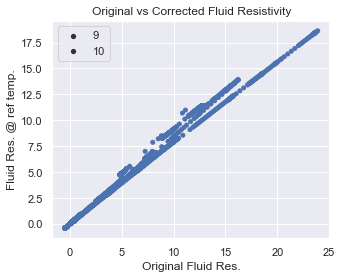

In [900]:
g = sns.scatterplot(data=df,x='FRES',y='FRESc',hue=None,edgecolor=None,size=10)
plt.gca().set_aspect(1)
plt.xlabel('Original Fluid Res.')
plt.ylabel('Fluid Res. @ ref temp.')
plt.title('Original vs Corrected Fluid Resistivity')
plt.show()

### Plot all boreholes: Bulk + fluid resistivity

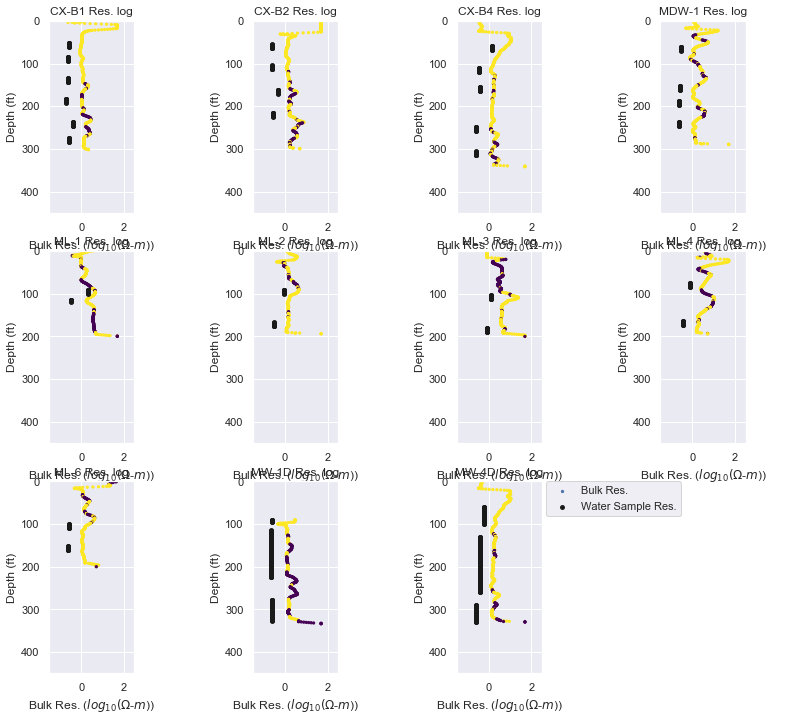

In [901]:
non_clays = ['SP','GP','SW','SM','SP-SM','ML','MH','SW-GW','SW-GP']
# df_plot = df.loc[mask_nonan(df,nan_cols),:]
# df_plot =  df[np.logical_and(np.logical_and(df.screen.notnull(),df.RILD.notnull()),df.lith=='SP')] 
# df_plot =  df[np.logical_and(df.RILD.notnull(),df.lith.isin(non_clays))] 
df_plot = df
s=5
f,axs=plt.subplots(3,4,figsize=(14,12))
plt.set_cmap('jet')
cmap = cm.get_cmap('viridis',len(df.lithnum_bin.unique()))  

for i,ax in enumerate(axs.flatten()):
    plt.sca(ax)
    if i == axs.size-1:
        plt.axis('off')
        continue
    nam = MWnames[i]
    ax.set_xlim([-1.5,2.5])
    ax.set_ylim([0,450])
    ax.invert_yaxis()
    d=df_plot.loc[nam].index
#     s2=plt.scatter(np.log10(df_plot.loc[nam].loc[:,'RILD']),d,
#                 s=s, label='Bulk Res.',c='k')#c=df_plot.loc[nam].loc[:,'lithnum_bin'],cmap=cmap)
    s1=plt.scatter(df_plot.loc[nam].loc[:,'logrild_conv'],d,
                s=s, label='Bulk Res.',c=df_plot.loc[nam].loc[:,'lithnum_bin'],cmap=cmap)

#     tds1 = plt.scatter(np.log10(df_plot.loc[nam].loc[:,'ec_fresc']),df.loc[nam].index,
#                        c='k',s=3*s,label='Water Sample Res.',vmin=0, vmax=15000)
    
    tds1 = plt.scatter(np.log10(cond2rho(df_plot.loc[nam].loc[:,'EC1'])),df.loc[nam].index,
                       c='k',s=3*s,label='Water Sample Res.',vmin=0, vmax=15000)
#     s2=plt.scatter(np.log10(df_plot.loc[nam].loc[:,'FRESc']),d,c='r',
#                 s=s,label='Fluid Res.')
    plt.ylabel('Depth (ft)')
    plt.xlabel('Bulk Res. ($log_{10}(\Omega$-$m$))');
    ax.set_aspect(1/50)
    plt.title(nam + ' Res. log');
    if i== axs.size-2:
        lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#         plt.colorbar(tds1)
# plt.savefig(figdir.joinpath('All_logs_lithology_bin.png'),dpi=500)

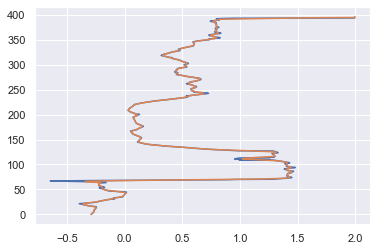

In [902]:
df2 = update_df2()
plt.plot(np.log10(df2.loc[df2.Well=='MW-9D','RILD']),df2.loc[df2.Well=='MW-9D','DEPT'])
plt.gca().invert_yaxis()

plt.plot(df2.loc[df2.Well=='MW-9D','logrild_conv'],df2.loc[df2.Well=='MW-9D','DEPT'])
plt.gca().invert_yaxis()

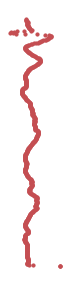

In [903]:
df_plot = df
s=10
f,ax=plt.subplots(1,1,figsize=(1,5))
ax.axis('off')
cmap = cm.get_cmap('viridis',2)
i=3
nam = MWnames[i]
color = np.ones(len(df_plot.loc[nam]))
color[df_plot.loc[nam].loc[:,'screen'].isna()]=0
ax.invert_yaxis()
d=df_plot.loc[nam].index
s1=plt.scatter(np.log10(df_plot.loc[nam].loc[:,'RILD']),d,
            s=s, label='Bulk Res.',c='r')

# plt.savefig(figdir.joinpath('RILD_red.pdf'),dpi=500,bbox_inches='tight')

In [904]:
from scipy import stats
def x_y_regression(xin,yin,cin,msk=None,plotslp=True,slpname='F',kdeplot=False,plotone2one=False,**kwargs):
    if msk is None:
        x=xin
        y=yin
        c=cin
    else:
        x=xin[msk]
        y=yin[msk]
        c=cin[msk]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    plt.set_cmap('viridis_r')
    f,ax = plt.subplots(1,figsize=(5,4))
    if kdeplot:
        sns.kdeplot(x,y)
    plt.scatter(x,y,c=c,**kwargs)
    plt.plot(x,slope*x + intercept,':k',label='L2 best fit')
    if plotone2one:
        one2one = np.linspace(x.min(),x.max())
        plt.plot(one2one,one2one,'k',label='y=x')
    if plotslp:
#         plt.text(x.max()-(x.max()-x.min())*.75,y.max()-(y.max()-y.min())*.10,'{} = {:.2f} \n$R^2$ = {:.2f}'.format(slpname,slope,r_value**2))
        plt.text(0.05,.80,'{} = {:.2f} \n$R^2$ = {:.2f} \nRMSE = {:.2f}'
                 .format(slpname,slope,r_value**2,np.sqrt(np.mean((y-x*slope)**2))),transform=ax.transAxes)
    else:
        plt.text(x.max()-(x.max()-x.min())*.75,y.max(),'$R^2$ = {:.2f} \nRMSE = {:.2f}'
                 .format(r_value**2,np.sqrt(np.mean((y-x*slope)**2))))
    return f,ax

### Applying Archie's Law: All measurements

<Figure size 432x288 with 0 Axes>

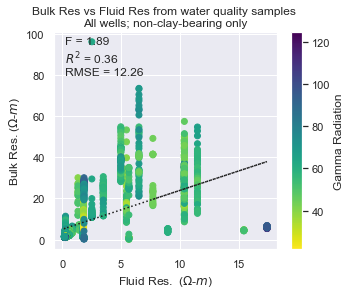

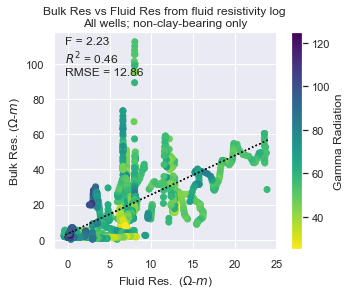

In [905]:
# df_plot = df.loc[mask_nonan(df,nan_cols),:]
# df_plot = df_plot.loc[mask_SP_only(df_plot,nan_cols),:]
# mask = mask_stds(df_plot,1.2,'RILD',nan_cols)
df_plot =  df[np.logical_and(np.logical_and(df.screen.notnull(),df.RILD.notnull()),df.lith.isin(non_clays))]
# df_plot =  df[np.logical_and(df.screen.notnull(),df.RILD.notnull())] 



x = cond2rho(df_plot.loc[:,'EC1f'])
y = df_plot.loc[:,'RILD']
c = pd.DataFrame(df_plot.index.to_list(),columns=['Well','DEPT'])['DEPT']
c = df_plot.loc[:,'GR']
f,ax1 = x_y_regression(x,y,c);
ax1.set_title('Bulk Res vs Fluid Res from water quality samples \nAll wells; non-clay-bearing only')
plt.xlabel('Fluid Res.  ($\Omega$-$m$)')
plt.ylabel('Bulk Res. ($\Omega$-$m$)')
cb = plt.colorbar()
cb.set_label('Gamma Radiation', rotation=90)
plt.savefig(figdir.joinpath('FRESvEC1f_non_clay.png'),dpi=300)


df_plot = df[np.logical_and(np.logical_and(df.RILD.notnull(),df.FRES.notnull()),df.lith.isin(non_clays))]

# df_plot =  df[np.logical_and(df.RILD.notnull(),df.FRES.notnull())] 

x = df_plot.loc[:,'FRES']
y = df_plot.loc[:,'RILD']
# c = pd.DataFrame(df_plot.index.to_list(),columns=['Well','DEPT'])['DEPT']
c = df_plot.loc[:,'GR']
f,ax2 = x_y_regression(x,y,c,vmin=25,vmax=125);

ax2.set_title('Bulk Res vs Fluid Res from fluid resistivity log \nAll wells; non-clay-bearing only')
plt.xlabel('Fluid Res.  ($\Omega$-$m$)')
plt.ylabel('Bulk Res. ($\Omega$-$m$)')
cb = plt.colorbar()
cb.set_label('Gamma Radiation', rotation=90)
# plt.savefig(figdir.joinpath('FRESvRILD_non_clay.png'),dpi=300)

### Archie's Law: borehole-by-borehole 

<Figure size 432x288 with 0 Axes>

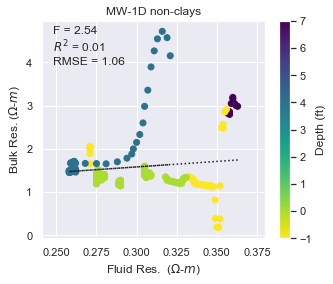

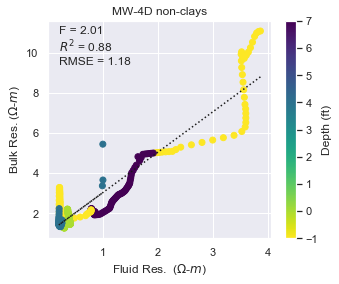

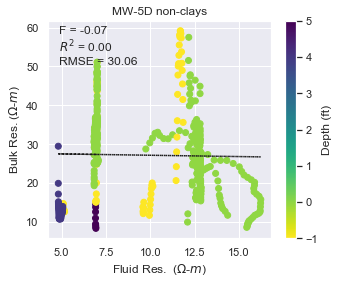

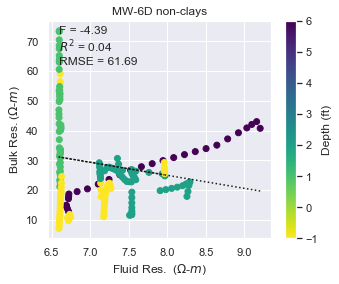

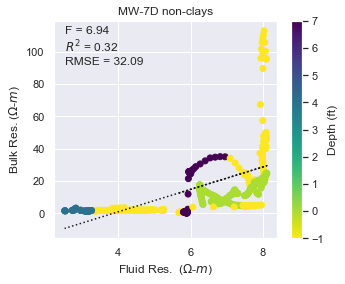

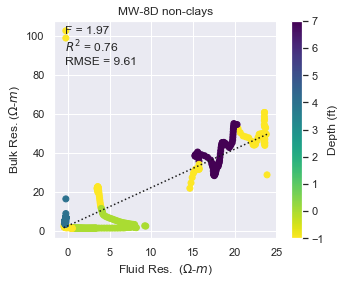

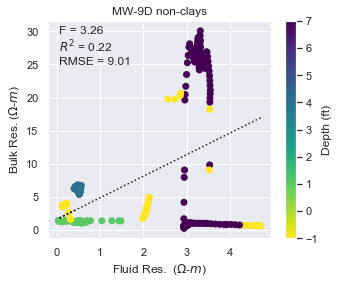

In [906]:

# df_plot =  df[np.logical_and(df.FRES.notnull(),df.RILD.notnull())] 
df_plot = df[np.logical_and(np.logical_and(df.RILD.notnull(),df.FRES.notnull()),df.lith.isin(non_clays))] 

# mask = mask_nonan(df_plot,nan_cols)

for i,nam in enumerate(MPWSPnames):
    x = df_plot.loc[nam].loc[:,'FRES']
    y = df_plot.loc[nam].loc[:,'RILD']
    c = df_plot.loc[nam].index
    c = df_plot.loc[nam].loc[:,'aqnum']
    f,ax = x_y_regression(x,y,c);
    ax.set_title(nam + ' non-clays')
    plt.xlabel('Fluid Res.  ($\Omega$-$m$)')
    plt.ylabel('Bulk Res. ($\Omega$-$m$)')
    cb = plt.colorbar()
    cb.set_label('Depth (ft)', rotation=90)
#     plt.savefig(figdir.joinpath('FRESvRILD_non_clay{}.png'.format(nam)),dpi=300)

### Archie's Law: aquifer-by-aquifer

In [907]:
aq_groupnames = df[df.AquiferGroup.notna()].AquiferGroup.unique()
aq_names = df[df.Aquifer.notna()].Aquifer.unique()
aq_names.sort()
aq_groupnum = -1*np.ones(len(df),dtype='Int32')
aqnum = -1*np.ones(len(df),dtype='Int32')

for i,nam in enumerate(aq_groupnames):
    aq_groupnum[df.AquiferGroup == nam] = i
df=df.assign(aq_groupnum=aq_groupnum)

for i,aq in enumerate(aq_names):
    aqnum[df.Aquifer == aq_names[i]] = i
df=df.assign(aqnum=aqnum)

<Figure size 432x288 with 0 Axes>

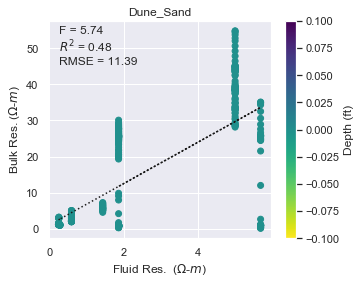

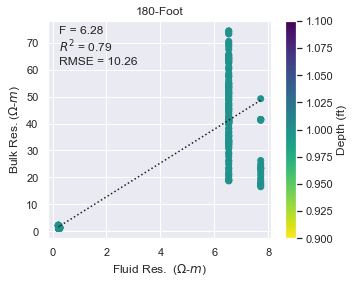

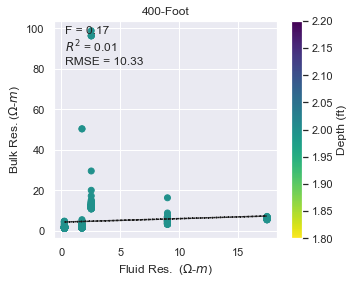

In [908]:
# df_plot =  df[np.logical_and(df.FRES.notnull(),df.RILD.notnull())] 
df_plot = df[np.logical_and(df.RILD.notnull(),df.EC1f.notnull())] 
df_plot = df_plot.assign(logrhoEC1f = np.log10(cond2rho(df_plot.loc[:,'EC1f'])))
df_plot = df_plot.assign(logrild = np.log10(df_plot.loc[:,'RILD']))

df[df.Aquifer==aq_names[0]]

for i,nam in enumerate(aq_groupnames):
    x = cond2rho(df_plot[df_plot.Aquifer==nam].loc[:,'EC1f'])
    y = df_plot[df_plot.Aquifer==nam].loc[:,'RILD']
    c = df_plot[df_plot.Aquifer==nam].loc[:,'aq_groupnum']
    f,ax = x_y_regression(x,y,c);
    ax.set_title(nam)
    plt.xlabel('Fluid Res.  ($\Omega$-$m$)')
    plt.ylabel('Bulk Res. ($\Omega$-$m$)')
    cb = plt.colorbar()
    cb.set_label('Depth (ft)', rotation=90)
#     plt.savefig(figdir.joinpath('WQvsRILD_'+nam+'.png'.format(nam)),dpi=300)

### Regression Tree v Classification Tree

In [909]:
def export_tree(export_dir,reg,max_depth,predictors,prefix='BagTree_',**kwargs):
    #Export graphs
    from sklearn import tree
    fig_suffix = '{numlevels}lvls_{predictors}.png'.format(numlevels=max_depth,predictors='-'.join(predictors))
    tree.export_graphviz(reg,out_file=export_dir.joinpath('tree.dot').as_posix(),filled=True,rounded=True,**kwargs)
    call(['dot', '-Tpng', figdir.joinpath('tree.dot').as_posix(), '-o',
    export_dir.joinpath(prefix+fig_suffix).as_posix(), '-Gdpi=150'])
    return

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10


<Figure size 432x288 with 0 Axes>

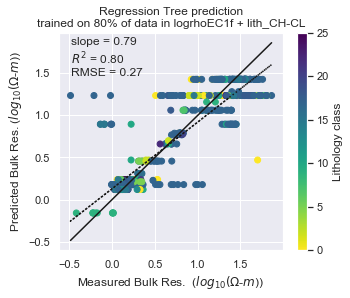

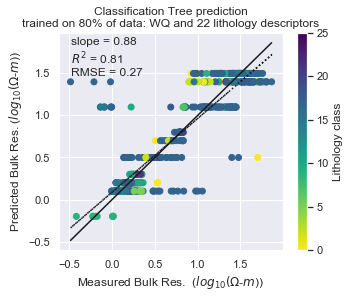

In [910]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from subprocess import call
np.random.seed(1)
######## Prediction variables  ################
# ## Predict from FRES and lith
# predicted = 'logrild'
# predictors = ['logfres','lithnum']
# df_testing = df[np.logical_and(np.logical_and(df.RILD.notnull(),~np.isnan(np.log(df.FRES.values))),df.lith.notnull())]


# #Predict from water quality samples and lith
predicted = ['logrild_bin','logrild']
predictors = ['logrhoEC1f']
df_testing = df[np.logical_and(np.logical_and(df.RILD.notnull(),df.EC1f.notnull()),df.lith.notnull())]
##############################################

df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))
df_testing = df_testing.sort_values(by='lith')
ohc = df_testing.loc[:,['lith']]
ohc =  pd.get_dummies(ohc,drop_first=True)
predictors = np.concatenate((predictors,ohc.columns.values))
df_testing = pd.get_dummies(df_testing,drop_first=False)

#Separate training from test data
y_all = df_testing.loc[:,predicted].values
df_train, df_test, y_train, y_test = train_test_split(df_testing, y_all, test_size=0.2)

y_train = y_train[:,0].astype(np.int)
y_test = y_test[:,1]

X_train = df_train.loc[:,predictors]
X_test = df_test.loc[:,predictors]

# Fit regression model
max_depth = 5

regr_1 = DecisionTreeRegressor(max_depth=max_depth)
regr_1.fit(X_train, y_train)

regr_2 = DecisionTreeClassifier(max_depth=max_depth)
regr_2.fit(X_train, y_train)


# Predict
y_1 = regr_1.predict(X_test)/10
y_2 = regr_2.predict(X_test)/10

#Plotting 
# mins = min(ax.get_ylim()[0],ax.get_xlim()[0])
# maxs = max(ax.get_ylim()[1],ax.get_xlim()[1])
# ax.plot(np.linspace(mins,maxs,10),np.linspace(mins,maxs,10))
# ax.set_aspect(1)
# cmap = cm.get_cmap('viridis',10 )  


f,ax = x_y_regression(y_test.squeeze(),
                      y_1,
                      df_test.lithnum,
                      plotslp=True,slpname='slope',plotone2one=True)#,cmap=cmap,vmin=25,vmax=100);
ax.set_title('Regression Tree prediction\ntrained on 80% of data in {}'.format(' + '.join(predictors[:2])))
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
cb = plt.colorbar()
cb.set_label('Lithology class', rotation=90)
fig_suffix = '{numlevels}lvls_{predictors}.png'.format(numlevels=max_depth,predictors='-'.join(predictors))
# plt.savefig(figdir.joinpath('RegTreePred_'+fig_suffix),bbox_inches='tight',dpi=300)


f,ax = x_y_regression(y_test.squeeze(),
                      y_2,
                      df_test.lithnum,
                      plotslp=True,slpname='slope',plotone2one=True,kdeplot=False)#,cmap=cmap,vmin=25,vmax=100);
# ax.set_title('Classification Tree prediction\ntrained on 80% of data in {}'.format(' + '.join(predictors[:2])))
ax.set_title('Classification Tree prediction\ntrained on 80% of data: WQ and 22 lithology descriptors')

plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
cb = plt.colorbar()
cb.set_label('Lithology class', rotation=90)
fig_suffix = '{numlevels}lvls_{predictors}.png'.format(numlevels=max_depth,predictors='-'.join(predictors))

# # #Export graphs
# plt.savefig(figdir.joinpath('ClasffsTreePred_'+fig_suffix),bbox_inches='tight',dpi=300)
# export_tree(figdir,regr_1,max_depth=5,predictors=predictors,prefix='Tree_',feature_names=predictors)

##### Interestingly, the classification tree, while it doesn't reduce the variance in the model, it does significantly reduce the bias, changing the slope from ~0.82 to ~0.96

### Bagging Trees for an estimate of uncertainty

In [911]:
def bagged_trees2(df,predicted,predictors,estimator=DecisionTreeRegressor,
                 train_ratio=.20,n_repeat=10,train_test_cols=None,verbose=True,**kwargs):
    #Separate training from test data
    y_all = df.loc[:,predicted]
    df_train, df_test, y_train, y_test = train_test_split(df, y_all, test_size=train_ratio)

    if train_test_cols is  None:
        train_test_cols = [predicted,predicted]
    else:
        y_test = y_test.loc[:,[train_test_cols[1]]]

    X_test = df_test.loc[:,predictors]
    regs = []
    X_train = []
    y_train = []
    for i in range(n_repeat):
        samp = resample(df_train,replace=True)
        X_train.append(samp.loc[:,predictors])
        y_train.append(samp.loc[:,[train_test_cols[0]]])

    # Compute predictions
    y_predict = np.zeros((len(y_test), n_repeat))

    for i in range(n_repeat):
        regs.append(estimator(**kwargs))
        regs[-1].fit(X_train[i], y_train[i])
        y_predict[:, i] = regs[-1].predict(X_test)


    y_est = y_predict.mean(axis=1)
    y_error = np.zeros(y_test.size)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.power(y_test.values - y_predict,2).mean(axis=1)
    y_noise = 0 # didn't bootstrap the test values np.var(y_test.values)
    y_bias = (y_test.values.flatten() - np.mean(y_predict, axis=1))**2
    y_var = np.var(y_predict,axis=1)
    
    
    if verbose:
        print("{0:.4f} (MSE) = {1:.4f} (bias^2)"
              "+ {2:.4f} (var)".format(np.mean(y_error),
                                       np.mean(y_bias),
                                       np.mean(y_var)))
        print("{0:.4f} (MSE) = {1:.2f}% (bias^2)"
              "+ {2:.2f}% (var)".format(np.mean(y_error),
                                       100*np.mean(y_bias)/(np.mean(y_bias)+np.mean(y_var)),
                                       100*np.mean(y_var)/(np.mean(y_bias)+np.mean(y_var))))
    return regs,y_predict,(df_train, df_test, X_train, X_test, y_train, y_test)

### 4 lithology categories applied to bagged trees

In [912]:
lithnum = np.zeros(len(df),dtype=np.int32)
lithnum_red = np.zeros(len(df),dtype=np.int32)
lithnum_bin= np.zeros(len(df),dtype=np.int32)
lithnum_bin_a =np.zeros(len(df),dtype=np.int32)
lithnum_bin_b = np.zeros(len(df),dtype=np.int32)
lithnum_bin_2ft= np.zeros(len(df),dtype=np.int32)



lithnam = [l for l in df.lith.unique() if str(l)!='nan']
lithnam.sort()


#4 lithologies (groups from UCSC)
lithnam_red = ['C','G','M','S']
lithnam2red = np.zeros(np.size(lithnam),dtype=np.int)


for i,redlith in enumerate(lithnam_red):
    for j,lith in enumerate(lithnam):
        if lith.startswith(redlith):
            lithnam2red[lithnam.index(lith)]=i

#Binary: Set anything that contains "C" or starts with "M" as "Cb"; else "Sb"
lithnam_bin = ['Cb','Sb']          
lithnam2bin= np.ones(np.size(lithnam),dtype=np.int)
for j,lith in enumerate(lithnam):
    if ('C' in lith) or (lith.startswith('M')):
        lithnam2bin[lithnam.index(lith)]=0

#Assign to df
for i,lith in enumerate(lithnam):
    lithnum[df.lith == lithnam[i]] = i
    lithnum_red[df.lith == lithnam[i]] = lithnam2red[lithnam.index(lithnam[i])]
    lithnum_bin[df.lith == lithnam[i]] = lithnam2bin[lithnam.index(lithnam[i])]
#     lithnum_bin_a[df.lith_above == lithnam[i]] = lithnam2bin[lithnam.index(lithnam[i])]
#     lithnum_bin_b[df.lith_above == lithnam[i]] = lithnam2bin[lithnam.index(lithnam[i])]
    
df = df.assign(lithnum=lithnum)
df = df.assign(lithnum_red=lithnum_red)
df = df.assign(lithnum_bin=lithnum_bin)

df = df.assign(C=(lithnum_red==0).astype(np.int))
df = df.assign(G=(lithnum_red==1).astype(np.int))
df = df.assign(M=(lithnum_red==2).astype(np.int))
df = df.assign(S=(lithnum_red==3).astype(np.int))

df = df.assign(Cb=(lithnum_bin==0).astype(np.int))
df = df.assign(Sb=(lithnum_bin==1).astype(np.int))

df = df.assign(Cb_a=(lithnum_bin_a==0).astype(np.int))
df = df.assign(Sb_a=(lithnum_bin_a==1).astype(np.int))
df = df.assign(Cb_b=(lithnum_bin_b==0).astype(np.int))
df = df.assign(Sb_b=(lithnum_bin_b==1).astype(np.int))


### Create category of lith_above, lith_below, and lithnum_bin_conv

#Running average
wellids = df.index.levels[0].values
lithnum_bin_conv = np.zeros(len(df))
lith_above = np.zeros(len(df))
lith_below = np.zeros(len(df))
N=5 #Filter length
ind1 = 0
for nam in wellids:
    x= df.loc[nam].lithnum_bin.values
    ind2  = len(x) + ind1
    test = np.convolve(x, np.ones((N,))/N, mode='valid')
    lithnum_bin_conv[ind1:ind2] = np.r_[x[:int((N-1)/2)],test,x[-int((N-1)/2):]] #assign the original lith values to edge
    lith_above[ind1:ind2] = np.r_[x[:-1],np.nan]
    lith_below[ind1:ind2] = np.r_[np.nan,x[1:]]
    ind1=ind2


df = df.assign(lith_above=lith_above)
df = df.assign(lith_below=lith_below)
df= df.assign(lithnum_bin_conv=lithnum_bin_conv)

#### Bagged Classifiers trained on:
###### -Resistivity of water quality sample
###### -All 22 lithology classifiers

168.6358 (MSE) = 167.6248 (bias^2)+ 1.0110 (var)
168.6358 (MSE) = 99.40% (bias^2)+ 0.60% (var)


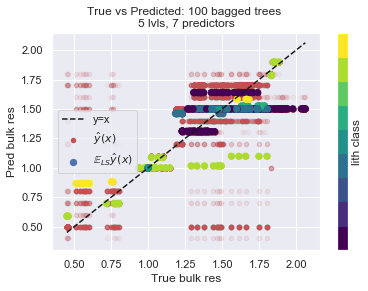

<Figure size 432x288 with 0 Axes>

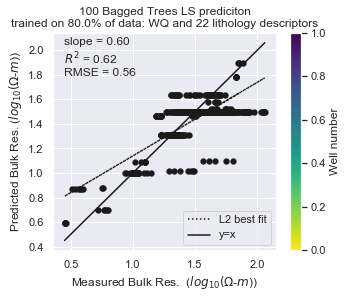

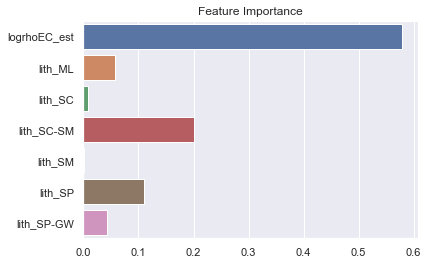

In [771]:
#Predict from water quality samples and lith
np.random.seed(1)
n_repeat = 100       # Number of iterations for computing expectations
train_ratio = .20
max_depth = 5
predicted = ['logrild_bin','logrild']
train_test_cols = ['logrild_bin','logrild']
# train_test_cols = None
predictors = ['logrhoEC_est']
estimator= DecisionTreeClassifier

df=update_FBS(df,'TDS1')

mask = nested_logicals(df,(df.RILD.notnull(),df.Rw_est.notnull(),df.lith.notnull(),df.Region=='Soquel'),func=np.logical_and)
df_testing = df[mask]


#     df_testing = df2[nested_logicals(df2,list_of_conditions,func=np.logical_and)]

##########################################

df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logrhoEC_est = np.log10(df_testing.loc[:,'Rw_est']))

df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logrilm = np.log10(df_testing.RILM))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))
df_testing = df_testing.sort_values(by='lith')
ohc = df_testing.loc[:,['lith']]
ohc =  pd.get_dummies(ohc,drop_first=True)
predictors = np.concatenate((predictors,ohc.columns.values))
df_testing = pd.get_dummies(df_testing,drop_first=False)

regs,y_predict,(df_train, df_test, X_train, X_test, y_train, y_test) = bagged_trees2(
    df_testing,predicted,predictors,
    estimator=estimator,
    train_ratio=train_ratio,
    train_test_cols=train_test_cols,
    n_repeat=n_repeat,
    max_depth=max_depth)

y_predict /=10
y_est = y_predict.mean(axis=1)


#Plot
f,ax = plt.subplots()
s=20
spreadcolor= "r"
cmap = cm.get_cmap('viridis',9)  
for i in range(n_repeat):
        plt.scatter(y_test,y_predict[:,i],c=spreadcolor,s=s,alpha=.05)
plt.scatter(y_test, y_est, c=spreadcolor,s=s,
         label=r"$\^y(x)$")
p = plt.scatter(y_test, y_est, c=df_test.lithnum,
         label=r"$\mathbb{E}_{LS} \^y(x)$",s=2*s,cmap=cmap)
one2one = np.linspace(y_test.min(),y_test.max())
plt.plot(one2one,one2one,'k--',label='y=x')
cb = f.colorbar(p,ax=ax,ticks=np.arange(len(predictors)))
cb.set_label('lith class', rotation=90)
# cb.ax.set_ylim([-.1,1.1])
pred_label = [pred[5:] for pred in predictors[1:]]
cb.ax.set_yticklabels(np.hstack(('not',pred_label)).astype(str))  # vertically oriented colorbar

plt.xlabel('True bulk res')
plt.ylabel('Pred bulk res')
plt.title('True vs Predicted: {} bagged trees \n'
          '{} lvls, {} predictors'.format(n_repeat,
                                          max_depth,
                                          len(predictors)))
plt.legend()
plt.show()

#Pred vs True
f,ax = x_y_regression(y_test.values.squeeze(),
                      y_est,
#                       df_test.aqnum,
#                       [int(nam[3]) for nam in pd.DataFrame(X_test.index.to_list(),columns=['Well','DEPT'])['Well']],
                      'k',
                      plotslp=True,slpname='slope',
                      plotone2one=True,
                      cmap=cmap,
                      edgecolors='k',
                      linewidths=0.25);


if len(predictors)>2:
    predictors_text_suffix = ' +...'
else:
    predictors_text_suffix = ''
predictors_text = ' + '.join(predictors[:2]) + predictors_text_suffix
ax.set_title('{} Bagged Trees LS prediciton\ntrained on {}% of data: WQ and 22 lithology descriptors'
             .format(n_repeat,(1-train_ratio)*100,predictors_text))
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
ax.legend(loc='lower right')
cb = f.colorbar(ax.collections[0],ax=ax)
cb.set_label('Well number', rotation=90)
# # cb.ax.set_ylim([-.1,1.1])
# pred_label = [pred for pred in predictors[1:]]
# cb.ax.set_yticklabels(np.hstack(('not',pred_label)).astype(str))  # vertically oriented colorbar
plt.savefig(figdir.joinpath('BaggedTreeLS_WQ_22lith.png'),bbox_inches='tight',dpi=300)
plt.show();


scores = 0
for i in range(n_repeat):
    scores += regs[i].feature_importances_
scores /= n_repeat
sns.barplot(x=scores,y=X_test.columns)
plt.title('Feature Importance');


#### Bagged Classifiers trained on:
###### -Resistivity of water quality sample
###### -4 lithology classifiers

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log10


77.5566 (MSE) = 76.1002 (bias^2)+ 1.4564 (var)
77.5566 (MSE) = 98.12% (bias^2)+ 1.88% (var)


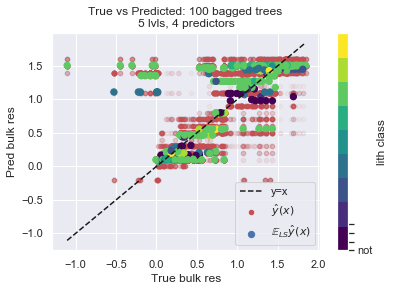

<Figure size 432x288 with 0 Axes>

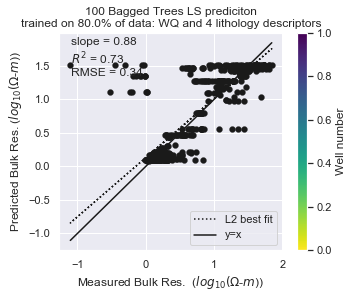

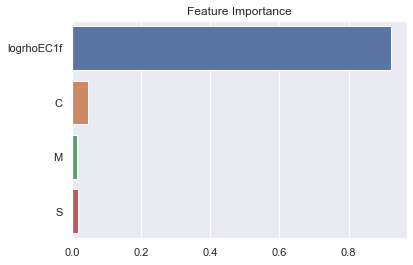

In [772]:
# #Predict from water quality samples and lith
np.random.seed(1)
n_repeat = 100       # Number of iterations for computing expectations
train_ratio = .20
max_depth = 5
predicted = ['logrild_bin','logrild']
train_test_cols = ['logrild_bin','logrild']
# train_test_cols = None
# predictors = ['logrhoEC1f','C','M','S']
predictors = ['logrhoEC1f','C','M','S']

estimator= DecisionTreeClassifier

df_testing = df[np.logical_and(np.logical_and(
    df.RILD.notnull(),df.EC1f.notnull()),df.lith.notnull())]
##########################################

df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))




regs,y_predict,(df_train, df_test, X_train, X_test, y_train, y_test) = bagged_trees2(
    df_testing,predicted,predictors,
    estimator=estimator,
    train_ratio=train_ratio,
    train_test_cols=train_test_cols,
    n_repeat=n_repeat,
    max_depth=max_depth)

y_predict /=10
y_est = y_predict.mean(axis=1)


#Plot
f,ax = plt.subplots()
s=20
spreadcolor= "r"
cmap = cm.get_cmap('viridis',9)  
for i in range(n_repeat):
        plt.scatter(y_test,y_predict[:,i],c=spreadcolor,s=s,alpha=.05)
plt.scatter(y_test, y_est, c=spreadcolor,s=s,
         label=r"$\^y(x)$")
p = plt.scatter(y_test, y_est, c=df_test.lithnum,
         label=r"$\mathbb{E}_{LS} \^y(x)$",s=2*s,cmap=cmap)
one2one = np.linspace(y_test.min(),y_test.max())
plt.plot(one2one,one2one,'k--',label='y=x')
cb = f.colorbar(p,ax=ax,ticks=np.arange(len(predictors)))
cb.set_label('lith class', rotation=90)
# cb.ax.set_ylim([-.1,1.1])
pred_label = [pred[5:] for pred in predictors[1:]]
cb.ax.set_yticklabels(np.hstack(('not',pred_label)).astype(str))  # vertically oriented colorbar

plt.xlabel('True bulk res')
plt.ylabel('Pred bulk res')
plt.title('True vs Predicted: {} bagged trees \n'
          '{} lvls, {} predictors'.format(n_repeat,
                                          max_depth,
                                          len(predictors)))
plt.legend()
plt.show()

#Pred vs True
f,ax = x_y_regression(y_test.values.squeeze(),
                      y_est,
                      'k',
#                       df_test.aqnum,
#                       [int(nam[3]) for nam in pd.DataFrame(X_test.index.to_list(),columns=['Well','DEPT'])['Well']],
                      plotslp=True,slpname='slope',
                      plotone2one=True,
                      cmap=cmap,
                      edgecolors='k',
                      linewidths=0.25);


if len(predictors)>2:
    predictors_text_suffix = ' +...'
else:
    predictors_text_suffix = ''
predictors_text = ' + '.join(predictors[:2]) + predictors_text_suffix
ax.set_title('{} Bagged Trees LS prediciton\ntrained on {}% of data: WQ and 4 lithology descriptors'
             .format(n_repeat,(1-train_ratio)*100,predictors_text))
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
ax.legend(loc='lower right')
cb = f.colorbar(ax.collections[0],ax=ax)
cb.set_label('Well number', rotation=90)
# # cb.ax.set_ylim([-.1,1.1])
# pred_label = [pred for pred in predictors[1:]]
# cb.ax.set_yticklabels(np.hstack(('not',pred_label)).astype(str))  # vertically oriented colorbar
plt.savefig(figdir.joinpath('BaggedTreeLS_WQ_4lith.png'),bbox_inches='tight',dpi=300)
plt.show();


scores = 0
for i in range(n_repeat):
    scores += regs[i].feature_importances_
scores /= n_repeat
sns.barplot(x=scores,y=X_test.columns)
plt.title('Feature Importance');

#### Bagged Classifiers trained on:
###### -Resistivity of water quality sample
###### -2 lithology classifiers

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10


77.3274 (MSE) = 75.7645 (bias^2)+ 1.5629 (var)
77.3274 (MSE) = 97.98% (bias^2)+ 2.02% (var)


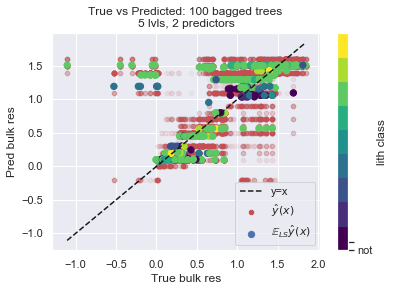

<Figure size 432x288 with 0 Axes>

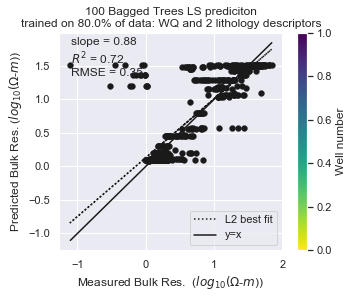

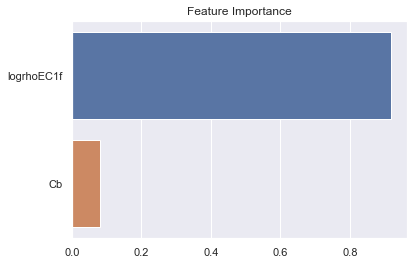

In [791]:
# #Predict from water quality samples and lith
np.random.seed(1)
n_repeat = 100       # Number of iterations for computing expectations
train_ratio = .20
max_depth = 5
predicted = ['logrild_bin','logrild']
train_test_cols = ['logrild_bin','logrild']
# train_test_cols = None
predictors = ['logrhoEC1f','Cb']
estimator= DecisionTreeClassifier

df_testing = df[np.logical_and(np.logical_and(
    df.RILD.notnull(),df.EC1f.notnull()),df.lith.notnull())]
##########################################

df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))




regs,y_predict,(df_train, df_test, X_train, X_test, y_train, y_test) = bagged_trees2(
    df_testing,predicted,predictors,
    estimator=estimator,
    train_ratio=train_ratio,
    train_test_cols=train_test_cols,
    n_repeat=n_repeat,
    max_depth=max_depth)

y_predict /=10
y_est = y_predict.mean(axis=1)


#Plot
f,ax = plt.subplots()
s=20
spreadcolor= "r"
cmap = cm.get_cmap('viridis',9)  
for i in range(n_repeat):
        plt.scatter(y_test,y_predict[:,i],c=spreadcolor,s=s,alpha=.05)
plt.scatter(y_test, y_est, c=spreadcolor,s=s,
         label=r"$\^y(x)$")
p = plt.scatter(y_test, y_est, c=df_test.lithnum,
         label=r"$\mathbb{E}_{LS} \^y(x)$",s=2*s,cmap=cmap)
one2one = np.linspace(y_test.min(),y_test.max())
plt.plot(one2one,one2one,'k--',label='y=x')
cb = f.colorbar(p,ax=ax,ticks=np.arange(len(predictors)))
cb.set_label('lith class', rotation=90)
# cb.ax.set_ylim([-.1,1.1])
pred_label = [pred[5:] for pred in predictors[1:]]
cb.ax.set_yticklabels(np.hstack(('not',pred_label)).astype(str))  # vertically oriented colorbar

plt.xlabel('True bulk res')
plt.ylabel('Pred bulk res')
plt.title('True vs Predicted: {} bagged trees \n'
          '{} lvls, {} predictors'.format(n_repeat,
                                          max_depth,
                                          len(predictors)))
plt.legend()
plt.show()

#Pred vs True
f,ax = x_y_regression(y_test.values.squeeze(),
                      y_est,
                      'k',
#                       [int(nam[3]) for nam in pd.DataFrame(X_test.index.to_list(),columns=['Well','DEPT'])['Well']],
                      plotslp=True,slpname='slope',
                      plotone2one=True,
                      cmap=cmap,
                      edgecolors='k',
                      linewidths=0.25);


if len(predictors)>2:
    predictors_text_suffix = ' +...'
else:
    predictors_text_suffix = ''
predictors_text = ' + '.join(predictors[:2]) + predictors_text_suffix
ax.set_title('{} Bagged Trees LS prediciton\ntrained on {}% of data: WQ and 2 lithology descriptors'
             .format(n_repeat,(1-train_ratio)*100,predictors_text))
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
ax.legend(loc='lower right')
cb = f.colorbar(ax.collections[0],ax=ax)
cb.set_label('Well number', rotation=90)


# plt.savefig(figdir.joinpath('BaggedTreeLS_WQ_2lith.png'),bbox_inches='tight',dpi=300)
# plt.show();

plt.figure()
scores = 0
for i in range(n_repeat):
    scores += regs[i].feature_importances_
scores /= n_repeat
sns.barplot(x=scores,y=X_test.columns)
plt.title('Feature Importance');

In [808]:
df2 = update_df2()
welldict = {}
for i,nam in enumerate(wellids):
    welldict[nam]=i
welldict

df=update_FBS(df,'TDS1')
df2=update_df2()

#### Bagged Classifiers trained on:
###### -Resistivity of water quality sample
###### -Binary lithology
###### -Aquifer number
###### -Convolved lithology: 2.5-ft-wide moving filter of binary lithology (Sand=1,Clay=0)

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log10


73.0962 (MSE) = 71.5322 (bias^2)+ 1.5639 (var)
73.0962 (MSE) = 97.86% (bias^2)+ 2.14% (var)


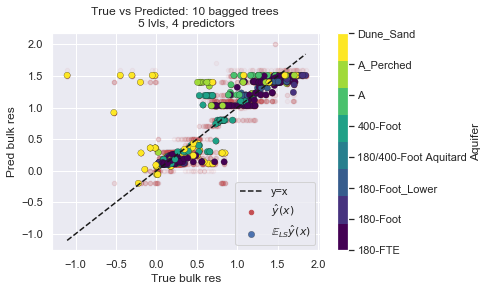

<Figure size 432x288 with 0 Axes>

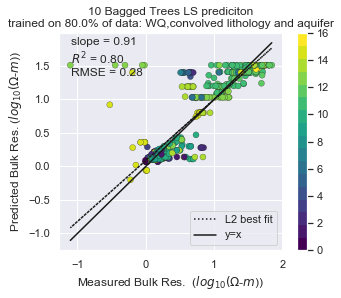

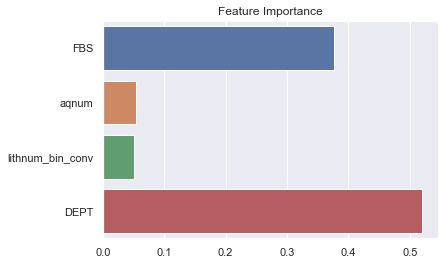

In [809]:
np.random.seed(1)

n_repeat = 10      # Number of iterations for computing expectations
train_ratio = .20
max_depth = 5


####Choose the input data set#########
# ## Predict from FRES and lith
# predicted = ['logrild']
# predictors = ['logfres','Sb']
# df_testing = df[np.logical_and(np.logical_and(df.RILD.notnull(),~np.isnan(np.log(df.FRES.values))),df.lith.notnull())]

#Predict from water quality samples and lith
predicted = ['logrild_bin','logrild']
train_test_cols=predicted

predictors = ['FBS','aqnum','lithnum_bin_conv','DEPT']
colorcolumn = 'aqnum'
estimator=DecisionTreeClassifier
# df_testing = df[np.logical_and(np.logical_and(df.RILD.notnull(),df.EC1f.notnull()),df.lith.notnull())]

# mask = nested_logicals(df2,(df2.RILD.notnull(),df2.EC1f.notnull(),df2.lith.notnull(),df2.Region=='Marina'),func=np.logical_and)
# df_testing = df[mask]

df_testing = df2[np.logical_and(np.logical_and(df2.RILD.notnull(),df2.EC1f.notnull()),df2.lith.notnull())]

#######################################

df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))

regs,y_predict,(df_train, df_test, X_train,X_test,y_train, y_test) = bagged_trees2(df_testing,predicted,predictors,
                              train_ratio=train_ratio,
                              train_test_cols=train_test_cols,
                              n_repeat=n_repeat,
                              estimator=estimator,
                              max_depth=max_depth)

y_predict /=10
y_est = y_predict.mean(axis=1)

#Plot
f,ax = plt.subplots()
s=20
spreadcolor= "r"
cmap = cm.get_cmap('viridis',len(df_testing.aqnum.unique()))  
for i in range(n_repeat):
        plt.scatter(y_test,y_predict[:,i],c=spreadcolor,s=s,alpha=.05)
y_est = y_predict.mean(axis=1)



plt.scatter(y_test, y_est, c=spreadcolor,s=s,
                label=r"$\^y(x)$")
p = plt.scatter(y_test, y_est, c=df_test.loc[:,colorcolumn],
                label=r"$\mathbb{E}_{LS} \^y(x)$",s=2*s,
                cmap=cmap,edgecolors='k',linewidth=.25)

one2one = np.linspace(y_test.min(),y_test.max())
plt.plot(one2one,one2one,'k--',label='y=x')
cb = f.colorbar(p,ax=ax)#,ticks=np.arange(len(aq_names)))
cb.set_label('Aquifer', rotation=90)
cb.set_ticks(np.arange(len(aq_names)))
cb.ax.set_yticklabels(aq_names)  # vertically oriented colorbar


plt.xlabel('True bulk res')
plt.ylabel('Pred bulk res')
plt.title('True vs Predicted: {} bagged trees \n'
          '{} lvls, {} predictors'.format(n_repeat,
                                          max_depth,
                                          len(predictors)))
plt.legend()
plt.show()

#Pred vs True
c= [welldict[nam] for nam in df_test.Well.values]
cmap = cm.get_cmap('viridis',len(np.unique(c)))

f,ax = x_y_regression(y_test.values.squeeze(),
                      y_est,
                      c,
                      plotslp=True,slpname='slope',
                      edgecolors='k',linewidth=.25,cmap=cmap)#,vmin=25,vmax=100);
one2one = np.linspace(y_test.min(),y_test.max())
plt.plot(one2one,one2one,'k',label='y=x')
if len(predictors)>2:
    predictors_text_suffix = ' +...'
else:
    predictors_text_suffix = ''
predictors_text = ' + '.join(predictors[:2]) + predictors_text_suffix
ax.set_title('{} Bagged Trees LS prediciton\ntrained on {}% of data: WQ,convolved lithology and aquifer'
             .format(n_repeat,(1-train_ratio)*100,predictors_text))
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
ax.legend(loc='lower right')
cb = f.colorbar(ax.collections[0])
# cb = f.colorbar(ax.collections[0],ax=ax,ticks=np.arange(len(predictors)))
# cb.set_label('Reduced lith class', rotation=90)
# cb.ax.set_ylim([-.1,1.1])
# cb.ax.set_yticklabels(np.hstack(('not',predictors[1:])).astype(str))  # vertically oriented colorbar
# plt.savefig(figdir.joinpath('BaggedTreeLS_WQ_lithconv_aqnum.png'),bbox_inches='tight',dpi=300)
plt.show();

scores = 0
for i in range(n_repeat):
    scores += regs[i].feature_importances_
scores /= n_repeat
sns.barplot(x=scores,y=X_test.columns)
plt.title('Feature Importance');
# plt.savefig(figdir.joinpath('FeatureImportance.png'),bbox_inches='tight',dpi=300)
# export_tree(figdir,regs[0],max_depth=5,predictors=predictors,prefix='Tree_',feature_names=predictors)

### Aakash's suggestions
--train on some wells, predict the remaining

--train on different combinations (or grouped depth intervals)

### Uncertainty estimate: effect of changing the train/test groups

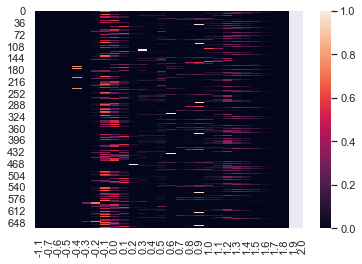

In [810]:
# plt.imshow(test.predict_proba(X_test))
test = regs[0]
f,ax=plt.subplots()
sns.heatmap(test.predict_proba(X_test),xticklabels=np.sort(df_testing.logrild_bin.unique())/10,ax=ax)

In [301]:
from numpy.linalg import norm
n_repeat = 100       # Number of iterations for computing expectations
train_ratio = .20
max_depth = 5


####Choose the input data set#########
# ## Predict from FRES and lith
# predicted = ['logrild']
# predictors = ['logfres','Sb']
# df_testing = df[np.logical_and(np.logical_and(df.RILD.notnull(),~np.isnan(np.log(df.FRES.values))),df.lith.notnull())]

#Predict from water quality samples and lith
predicted = ['logrild_bin','logrild']
train_test_cols=predicted

predictors = ['logrhoEC1f','aqnum','lithnum_bin_conv','DEPT']
colorcolumn = 'aqnum'
estimator=DecisionTreeClassifier
df_testing = df2[np.logical_and(np.logical_and(df2.RILD.notnull(),df2.EC1f.notnull()),df2.lith.notnull())]
#######################################

df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))

n_it = 100
MSE = []
norm_err=[]
for s in range(n_it):
    if np.mod(s,5)==0:
        print('iteration',s)
    np.random.seed(s)
    regs,y_predict,(df_train, df_test, X_train,X_test,y_train, y_test) = bagged_trees2(df_testing,predicted,predictors,
                                  train_ratio=train_ratio,
                                  train_test_cols=train_test_cols,
                                  n_repeat=n_repeat,
                                  verbose=False,  
                                  estimator=estimator,
                                  max_depth=max_depth)

    y_predict /=10
    MSE.append(np.power(y_predict - np.tile(y_test,n_repeat),2).mean())
    norm_err.append(norm(y_predict - np.tile(y_test.values,[1,n_repeat]),ord=2)
                    /norm(np.tile(y_test.values,[1,n_repeat]),ord=2))

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10


iteration 0
iteration 5
iteration 10
iteration 15
iteration 20
iteration 25
iteration 30
iteration 35
iteration 40
iteration 45
iteration 50
iteration 55


KeyboardInterrupt: 

In [ ]:
# plt.hist(norm_err,label='Norm. Error')
sns.distplot(norm_err,label='Norm. Error')
plt.vlines(norm_err[0],0,25,colors='r',label='Displayed results')
plt.title('Normalized error versus random seed: {} iterations'
          .format(n_it))
plt.xlabel('normalized error')
plt.ylabel('count')
plt.legend()
# plt.savefig(figdir.joinpath('ErrorHist.png'),bbox_inches='tight',dpi=300)

### Error analysis: where are the high errors coming from?

In [811]:
df_test = df_test.assign(y_est=y_est)
df_test = df_test.assign(err=df_test.logrild - df_test.y_est)
df_test = df_test.assign(err_sq=(df_test.logrild - df_test.y_est)**2)

In [812]:
df_test.sort_values('err_sq',ascending=False).head(10)

,Well,DEPT,RILM,RILD,GR,SP,X,Y,Region,lith,...,logrild_conv,aq_groupnum,FBS,logrhoEC1f,logrild,logrild_bin,logfres,y_est,err,err_sq
7169,MW-7D,66.0,0.48611,0.07871,43.547,-10.13400,608139.525600,4.062977e+06,Marina,SP,...,-0.356220,0,1.0,0.753994,-1.103970,-11,0.770042,1.51,-2.613970,6.832840
7171,MW-7D,67.0,0.47336,0.35701,56.457,56.44000,608139.525600,4.062977e+06,Marina,SP,...,-0.192672,0,1.0,0.753994,-0.447320,-4,0.771146,1.51,-1.957320,3.831100
7172,MW-7D,67.5,1.17330,0.49701,58.531,74.65300,608139.525600,4.062977e+06,Marina,SP,...,-0.020975,0,1.0,0.753994,-0.303635,-3,0.771661,1.51,-1.813635,3.289271
8583,MW-9D,68.0,1.04170,0.63439,88.677,NaN,608993.553300,4.066033e+06,Marina,ML,...,0.055322,0,2.0,0.268895,-0.197644,-2,0.468200,1.40,-1.597644,2.552465
7161,MW-7D,62.0,0.48611,0.88882,34.713,0.12147,608139.525600,4.062977e+06,Marina,SP,...,-0.029938,0,1.0,0.753994,-0.051186,-1,0.765818,1.51,-1.561186,2.437302
7163,MW-7D,63.0,0.48611,0.95788,39.920,-9.51430,608139.525600,4.062977e+06,Marina,SP,...,-0.043573,0,1.0,0.753994,-0.018689,0,0.766859,1.51,-1.528689,2.336890
8580,MW-9D,66.5,0.31964,0.29778,80.047,NaN,608993.553300,4.066033e+06,Marina,MH,...,-0.299786,0,2.0,0.268895,-0.526104,-5,0.468643,0.92,-1.446104,2.091218
3805,ML-4,79.0,3.90640,3.23350,53.497,-52.05600,608473.152868,4.073663e+06,Marina,SP,...,0.510057,0,2.0,-0.111699,0.509673,5,NaN,1.40,-0.890327,0.792682
3054,ML-2,98.5,3.47600,3.38760,42.709,-6.96310,608226.608142,4.073735e+06,Marina,SW,...,0.533752,0,2.0,-0.061000,0.529892,5,NaN,1.40,-0.870108,0.757088
3801,ML-4,77.0,4.16280,3.47930,56.012,-54.26700,608473.152868,4.073663e+06,Marina,SP,...,0.537703,0,2.0,-0.111699,0.541492,5,NaN,1.40,-0.858508,0.737036


Text(0.5, 1.0, 'Distribution of water resistivity values')

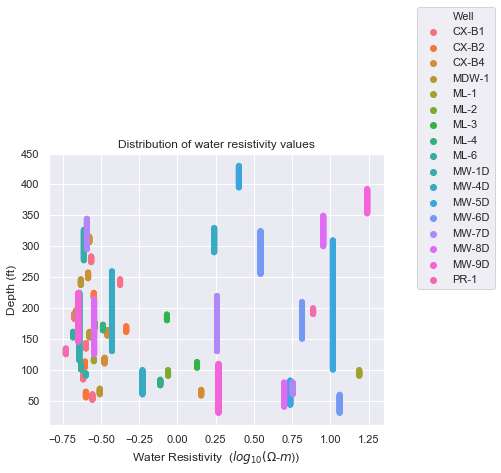

In [813]:
f,ax = plt.subplots(figsize=(6,5))
sns.scatterplot(data=df_testing,x='logrhoEC1f',y='DEPT',hue='Well',ax=ax,linewidth=0)
plt.legend(loc=(1.1, .5))
plt.xlabel('Water Resistivity  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Depth (ft)')
plt.title('Distribution of water resistivity values')
# plt.savefig(figdir.joinpath('WaterResVsDepth.png'),dpi=300,bbox_inches='tight')

### Slicing data different ways: 
#### Holding out one well to predict
#### Holding out one screened interval to predict

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log10


<Figure size 432x288 with 0 Axes>

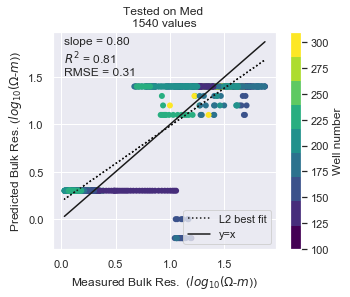

<Figure size 432x288 with 0 Axes>

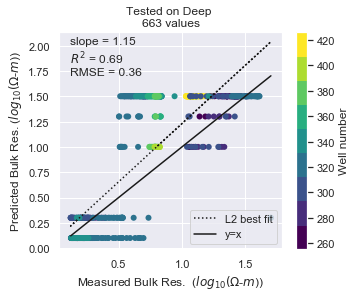

<Figure size 432x288 with 0 Axes>

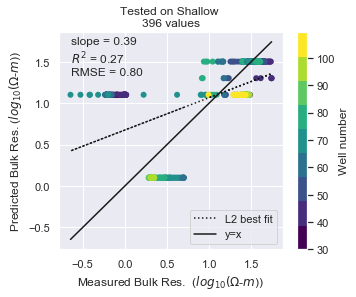

In [305]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,GradientBoostingClassifier
np.random.seed(1)

n_repeat = 50     # Number of iterations for computing expectations
train_ratio = .20
max_depth = 10
n_estimators = n_repeat



####Choose the input data set#########
#Predict from water quality samples and lith
predicted = 'logrild_conv_bin'
train_test_cols=predicted

predictors = ['FBS','aq_groupnum','lithnum_bin_conv']
estimator=BaggingClassifier(DecisionTreeClassifier(
    max_depth=max_depth),n_estimators=n_estimators)
# estimator = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth))
# estimator=GradientBoostingClassifier(n_estimators=n_estimators,max_depth=3)



# for nam in wellids:
# for nam in wellids:
# testwell = nam

    
# trainwells = [wellid for wellid in wellids if wellid!=testwell]
df2 = update_df2()
df_testing = df2[np.logical_and(np.logical_and(df2.RILD.notnull(),df2.TDS1.notnull()),df2.lith.notnull())]
df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logrild_conv_bin = (np.round(df_testing.logrild_conv,1)*10).values.astype(int))

df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))
# df_testing = df_testing.loc[df_testing.lithnum_bin_conv==1,:]



#     #####################################
#     #One hot encoding if doing all lith
#     ohc = df_testing.loc[:,['lith']]
#     ohc =  pd.get_dummies(ohc,drop_first=True)
#     predictors = np.concatenate((predictors,ohc.columns.values))
#     df_testing = pd.merge(df_testing, ohc, how ='inner', on =df_testing.index) 
#     #####

#######################################
#Separate training from test data


for scrn in df_testing.screen.unique():
    df_train = df_testing.loc[~(df_testing.screen==scrn),:]
    df_test = df_testing.loc[df_testing.screen==scrn,:]


    #     df_train = df_testing.loc[df_testing.Well.isin(trainwells)]
    #     df_test = df_testing.loc[df_testing.Well==testwell]



    #         df_train = df_testing[np.logical_and(df_testing.Well==nam,df_testing.screen==scrn)]
    #         df_test = df_testing[~np.logical_and(df_testing.Well==nam,df_testing.screen==scrn)]

    X_train = df_train.loc[:,predictors]
    y_train = df_train.loc[:,predicted]

    X_test = df_test.loc[:,predictors]
#     y_test = df_test.loc[:,predicted]
    y_test = df_test.loc[:,'logrild']


    # X = df_testing.loc[:,predictors]
    # y = df_testing.loc[:,predicted]
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_ratio)

    estimator.fit(X_train,y_train)
    y_predict = estimator.predict(X_test)
    y_train_predict = estimator.predict(X_train)


    y_train = y_train/10
    y_predict = y_predict/10
    y_train_predict = y_train_predict/10
#     y_test =y_test/10


    #     f,ax = x_y_regression(y_train.values.squeeze(),
    #                           y_train_predict.squeeze(),
    #                           'k',
    #     #                       [int(nam[3]) for nam in pd.DataFrame(y_train.index.to_list(),columns=['Well','DEPT'])['Well']],
    #                           plotslp=True,slpname='slope',plotone2one=True,
    #                           edgecolors='k',linewidth=.25,cmap='Greys')#,vmin=25,vmax=100);
    #     plt.legend(loc='right')
    #     plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
    #     plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
    #     plt.title('Training data ' + testwell)
    #     plt.show()
    cmap = cm.get_cmap('viridis',9)

    f,ax = x_y_regression(y_test.values.squeeze(),
                          y_predict.squeeze(),
#                           [int(nam[3]) for nam in df_test.Well],
                          df_test.DEPT,
                          plotslp=True,slpname='slope',plotone2one=True,
                          edgecolors='k',linewidth=0,cmap=cmap)#,vmin=25,vmax=100);
    plt.legend(loc='lower right')
    # ax.set_xlim(-.75,1.3)
    cb = plt.colorbar()
    cb.ax.set_ylabel('Well number')
    plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
    plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
    plt.title('Tested on ' + scrn + ' \n' + str(y_predict.size) + ' values')
#     plt.savefig(figdir.joinpath('Teston{}_noclay.png'.format(scrn)),dpi=300,bbox_inches='tight')
    plt.show()

In [927]:
df = update_FBS(df,'TDS1')
df2 = update_df2()


In [985]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,GradientBoostingClassifier
np.random.seed(1)

n_repeat = 25     # Number of iterations for computing expectations
max_depth = 10
n_estimators = n_repeat


####Choose the input data set#########
#Predict from water quality samples and lith
predicted = 'logrild_conv_bin'
train_test_cols=predicted

predictors = ['FBS','aq_groupnum','X','Y','C']
colorcolumn = 'aq_groupnum'
estimator=BaggingClassifier(DecisionTreeClassifier(
    max_depth=max_depth,max_leaf_nodes=20),n_estimators=n_estimators)
# estimator = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth))
# estimator=GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth)
# estimator=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)


y_preds = []
y_tests = []
y_color = []

list_of_conditions = (df2.RILD.notnull(),
                      df2.FBS.notnull(),
                      df2.lith.notnull(),
                      df2.Sb_a.notnull(),
                      df2.Sb_b.notnull(),
                      df2.Y.notnull())
df_testing = df2[nested_logicals(df2,list_of_conditions,func=np.logical_and)]

df_testing = df_testing.assign(logrhoEC_est = np.log10(df_testing.loc[:,'Rw_est']))
df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logrild_conv_bin = (np.round(df_testing.logrild_conv,1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))
# df_testing = df_testing.loc[df_testing.lithnum_bin_conv==1,:]

allwells = df_testing.Well.unique()
print('Wells with available data:',allwells)
for nam in allwells:
    testwell = nam
    print('testing on',nam)
    trainwells = [wellid for wellid in allwells if wellid!=testwell]


    #     #####################################
    #     #One hot encoding if doing all lith
    #     ohc = df_testing.loc[:,['lith']]
    #     ohc =  pd.get_dummies(ohc,drop_first=True)
    #     predictors = np.concatenate((predictors,ohc.columns.values))
    #     df_testing = pd.merge(df_testing, ohc, how ='inner', on =df_testing.index) 
    #     #####

    #######################################
    #Separate training from test data


    # for nam in df_testing.Well.unique():
    #     df_train = df_testing.loc[~(df_testing.screen==scrn),:]
    #     df_test = df_testing.loc[df_testing.screen==scrn,:]


    df_train = df_testing.loc[df_testing.Well.isin(trainwells)]
    df_test = df_testing.loc[df_testing.Well==testwell]



    #         df_train = df_testing[np.logical_and(df_testing.Well==nam,df_testing.screen==scrn)]
    #         df_test = df_testing[~np.logical_and(df_testing.Well==nam,df_testing.screen==scrn)]

    X_train = df_train.loc[:,predictors]
    y_train = df_train.loc[:,predicted]

    X_test = df_test.loc[:,predictors]
#     y_test = df_test.loc[:,predicted]
    y_test = df_test.loc[:,'logrild']

    # X = df_testing.loc[:,predictors]
    # y = df_testing.loc[:,predicted]
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_ratio)

    estimator.fit(X_train,y_train)
    y_predict = estimator.predict(X_test)
    y_train_predict = estimator.predict(X_train)


    y_train = y_train/10
    y_predict = y_predict/10
    y_train_predict = y_train_predict/10
    
    y_tests.append(y_test.values)
    y_preds.append(y_predict)
    y_color.append(welldict[nam]* np.ones(np.size(y_predict)))

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log10


Wells with available data: ['CX-B1' 'CX-B2' 'CX-B4' 'MDW-1' 'ML-1' 'ML-2' 'ML-3' 'ML-4' 'ML-6'
 'MW-1D' 'MW-4D' 'MW-5D' 'MW-6D' 'MW-7D' 'MW-8D' 'MW-9D' 'PR-1' 'SC-8A'
 'SC-8B' 'SC-8C' 'SC-8D' 'SC-8E' 'SC-8F' 'SC-9D' 'SC-9I' 'SC-9S' 'SC-A2D'
 'SC-A2I' 'SC-A2S' 'SC-A8D' 'SC-A8I' 'SC-A8S']
testing on CX-B1
testing on CX-B2
testing on CX-B4
testing on MDW-1
testing on ML-1
testing on ML-2
testing on ML-3
testing on ML-4
testing on ML-6
testing on MW-1D
testing on MW-4D
testing on MW-5D
testing on MW-6D
testing on MW-7D
testing on MW-8D
testing on MW-9D
testing on PR-1
testing on SC-8A
testing on SC-8B
testing on SC-8C
testing on SC-8D
testing on SC-8E
testing on SC-8F
testing on SC-9D
testing on SC-9I
testing on SC-9S
testing on SC-A2D
testing on SC-A2I
testing on SC-A2S
testing on SC-A8D
testing on SC-A8I
testing on SC-A8S


In [1003]:
df.screen.unique()

array([nan, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 'Shallow', 'Med', 'Deep'],
      dtype=object)

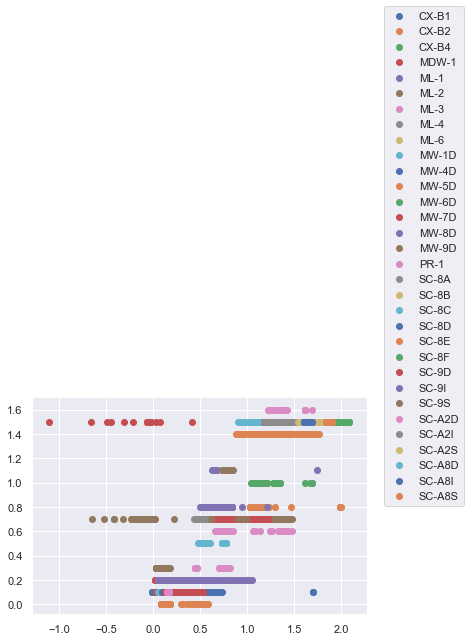

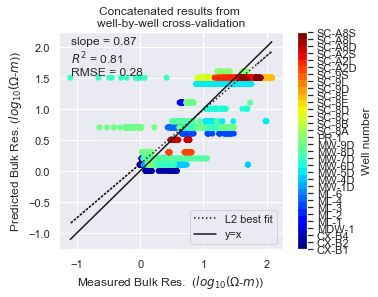

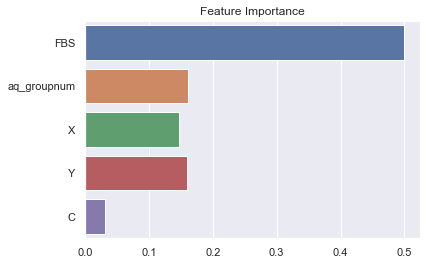

In [1001]:
#Plot    
for nam,y_test,y_predict in zip(wellids,y_tests,y_preds):
    plt.scatter(y_test,y_predict,label=nam)
plt.legend(loc=(1.05,.5))

c = np.concatenate( y_color, axis=0 )
cmap = cm.get_cmap('jet',len(np.unique(c)))
f,ax = x_y_regression(np.concatenate( y_tests, axis=0 ),
                      np.concatenate( y_preds, axis=0 ),
                      c,
                      plotslp=True,slpname='slope',plotone2one=True,
                      edgecolors='k',linewidth=0,cmap=cmap)#,vmin=25,vmax=100);
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
plt.title('Concatenated results from \nwell-by-well cross-validation')
plt.legend(loc='lower right')
cb = plt.colorbar()
cb.ax.set_ylabel('Well number')
ticks=  [num for nam,num in welldict.items() if (nam in allwells)]
ticklabels = [nam for nam,num in welldict.items() if (nam in allwells)]

cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)


# plt.savefig(figdir.joinpath('CVwell_noclay2.png'),dpi=300,bbox_inches='tight')
plt.show()

plt.figure()
scores = 0
for i in range(len(estimator.estimators_)):
    scores += np.asarray(estimator.estimators_).flatten()[i].feature_importances_
scores /= n_repeat
sns.barplot(x=scores,y=X_test.columns)
plt.title('Feature Importance');
# plt.savefig(figdir.joinpath('FeatureImportance.png'),bbox_inches='tight',dpi=300)
# export_tree(figdir,regs[0],max_depth=5,predictors=predictors,prefix='Tree_',feature_names=predictors)

## ***IN PROGRESS:***
### Train on MPWSP data, test on Soquel Creek Data


16

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log10
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log10
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log10
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log10
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log10
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log10
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log10
/Users/ianpg/anaconda/envs/

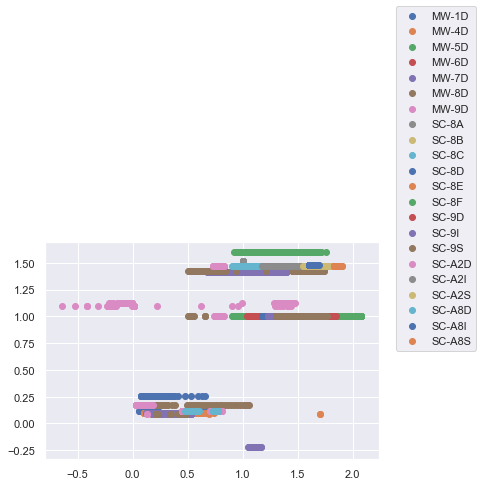

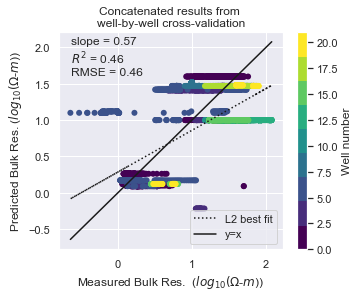

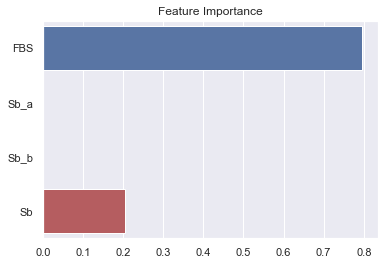

In [449]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,GradientBoostingClassifier
np.random.seed(1)

n_repeat = 100     # Number of iterations for computing expectations
train_ratio = .20
max_depth = 10
n_estimators = n_repeat


####Choose the input data set#########
#Predict from water quality samples and lith
predicted = 'logrild_conv_bin'
train_test_cols=predicted

predictors = ['FBS','Sb_a','Sb_b','Sb']
colorcolumn = 'aq_groupnum'
estimator=BaggingClassifier(DecisionTreeClassifier(
    max_depth=max_depth,max_leaf_nodes=20),n_estimators=n_estimators)
# estimator = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth))
# estimator=GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth)
# estimator=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)


y_preds = []
y_tests = []
y_color = []

for nam in wellids:
    testwell = nam

    
    list_of_conditions = (df2.RILD.notnull(),df2.FBS.notnull(),df2.lith.notnull(),df2.Sb_a.notnull(),df2.Sb_b.notnull())
    df_testing = df2[nested_logicals(df2,list_of_conditions,func=np.logical_and)]
    

    trainwells = [wellid for wellid in wellids if wellid!=testwell]
#     df_testing = df2[np.logical_and(np.logical_and(df2.RILD.notnull(),df2.FBS.notnull()),df2.lith.notnull())]
    df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
    df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
    df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),2)*100).values.astype(int))
    df_testing = df_testing.assign(logrild_conv_bin = (np.round(df_testing.logrild_conv,2)*100).values.astype(int))
    df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))
#     df_testing = df_testing.loc[df_testing.lithnum_bin_conv==1,:]
#


    #     #####################################
    #     #One hot encoding if doing all lith
    #     ohc = df_testing.loc[:,['lith']]
    #     ohc =  pd.get_dummies(ohc,drop_first=True)
    #     predictors = np.concatenate((predictors,ohc.columns.values))
    #     df_testing = pd.merge(df_testing, ohc, how ='inner', on =df_testing.index) 
    #     #####

    #######################################
    #Separate training from test data


    # for nam in df_testing.Well.unique():
    #     df_train = df_testing.loc[~(df_testing.screen==scrn),:]
    #     df_test = df_testing.loc[df_testing.screen==scrn,:]


    df_train = df_testing.loc[df_testing.Well.isin(trainwells)]
    df_test = df_testing.loc[df_testing.Well==testwell]



    #         df_train = df_testing[np.logical_and(df_testing.Well==nam,df_testing.screen==scrn)]
    #         df_test = df_testing[~np.logical_and(df_testing.Well==nam,df_testing.screen==scrn)]

    X_train = df_train.loc[:,predictors]
    y_train = df_train.loc[:,predicted]

    X_test = df_test.loc[:,predictors]
#     y_test = df_test.loc[:,predicted]
    y_test = df_test.loc[:,'logrild']


    # X = df_testing.loc[:,predictors]
    # y = df_testing.loc[:,predicted]
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_ratio)

    estimator.fit(X_train,y_train)
    y_predict = estimator.predict(X_test)
    y_train_predict = estimator.predict(X_train)


    y_train = y_train/100
    y_predict = y_predict/100
    y_train_predict = y_train_predict/100
    
    y_tests.append(y_test.values)
    y_preds.append(y_predict)
#     y_color.append(int(nam[3])* np.ones(np.size(y_predict)))
    y_color.append(np.where(wellids==nam)[0][0]* np.ones(np.size(y_predict)))
    
    
#Plot    
for nam,y_test,y_predict in zip(wellids,y_tests,y_preds):
    plt.scatter(y_test,y_predict,label=nam)
plt.legend(loc=(1.05,.5))

cmap = cm.get_cmap('viridis',9)
f,ax = x_y_regression(np.concatenate( y_tests, axis=0 ),
                      np.concatenate( y_preds, axis=0 ),
                      np.concatenate( y_color, axis=0 ),
#                       df_testing.DEPT,
                      plotslp=True,slpname='slope',plotone2one=True,
                      edgecolors='k',linewidth=0,cmap=cmap)#,vmin=25,vmax=100);
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
plt.title('Concatenated results from \nwell-by-well cross-validation')
plt.legend(loc='lower right')
cb = plt.colorbar()
cb.ax.set_ylabel('Well number')
# plt.savefig(figdir.joinpath('CVwell_noclay2.png'),dpi=300,bbox_inches='tight')
plt.show()

plt.figure()
scores = 0
for i in range(len(estimator.estimators_)):
    scores += np.asarray(estimator.estimators_).flatten()[i].feature_importances_
scores /= n_repeat
sns.barplot(x=scores,y=X_test.columns)
plt.title('Feature Importance');
# plt.savefig(figdir.joinpath('FeatureImportance.png'),bbox_inches='tight',dpi=300)
# export_tree(figdir,regs[0],max_depth=5,predictors=predictors,prefix='Tree_',feature_names=predictors)


In [452]:
wellids

array(['MW-1D', 'MW-4D', 'MW-5D', 'MW-6D', 'MW-7D', 'MW-8D', 'MW-9D',
       'SC-8A', 'SC-8B', 'SC-8C', 'SC-8D', 'SC-8E', 'SC-8F', 'SC-9D',
       'SC-9I', 'SC-9S', 'SC-A2D', 'SC-A2I', 'SC-A2S', 'SC-A8D', 'SC-A8I',
       'SC-A8S'], dtype=object)

#### The bagging classifier ends up with nearly the exact same prediction as with the manually bagged trees. Difference is that with the manual approach, I can plot each of the predictions as an estimate of variance

In [276]:
# np.round(np.log10(df_testing.RILD)*20,1).unique()


In [300]:
sns.heatmap(estimator.predict_proba(X_test),xticklabels=estimator.classes_/10,cmap='Reds')
plt.xlabel('$log_{10}(\\rho)$')

AttributeError: 'BaggingRegressor' object has no attribute 'predict_proba'

In [183]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test,y_predict)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(conf, cmap=cmap, vmax=30, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xlabel('y_predict')
plt.ylabel('y_test')
plt.title('Confusion matrix')
plt.show()

ValueError: continuous is not supported

In [ ]:
y_all = df_testing.loc[:,predicted]
df_train, df_test, y_train, y_test = train_test_split(df_testing, y_all, test_size=train_ratio)

y_test = y_test.loc[:,'logrild']

X_test = df_test.loc[:,predictors]
regs = []
X_train = []
y_train = []
for i in range(n_repeat):
    samp = resample(df_train,replace=True)
    X_train.append(samp.loc[:,predictors])
    y_train.append(samp.loc[:,[train_test_cols[0]]])

# Compute predictions
y_predict = np.zeros((len(y_test), n_repeat))

for i in range(n_repeat):
    regs.append(estimator(**kwargs))
    regs[-1].fit(X_train[i], y_train[i])
    y_predict[:, i] = regs[-1].predict(X_test)


y_est = y_predict.mean(axis=1)
y_error = np.zeros(y_test.size)

# Bias^2 + Variance + Noise decomposition of the mean squared error
y_error = np.power(y_test.values - y_predict,2).mean(axis=1)
y_noise = 0 # didn't bootstrap the test values np.var(y_test.values)
y_bias = (y_test.values.flatten() - np.mean(y_predict, axis=1))**2
y_var = np.var(y_predict,axis=1)

print("{0:.4f} (MSE) = {1:.4f} (bias^2)"
      "+ {2:.4f} (var)".format(np.mean(y_error),
                               np.mean(y_bias),
                               np.mean(y_var)))
print("{0:.4f} (MSE) = {1:.2f}% (bias^2)"
      "+ {2:.2f}% (var)".format(np.mean(y_error),
                               100*np.mean(y_bias)/(np.mean(y_bias)+np.mean(y_var)),
                               100*np.mean(y_var)/(np.mean(y_bias)+np.mean(y_var))))




Tree: 0.0250 (error) = 0.0001 (bias^2)  + 0.0149 (var) + 0.0100 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0100 (noise)


/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF: 0.0194 (error) = 0.0009 (bias^2)  + 0.0085 (var) + 0.0100 (noise)
Ada: 0.0240 (error) = 0.0027 (bias^2)  + 0.0113 (var) + 0.0100 (noise)


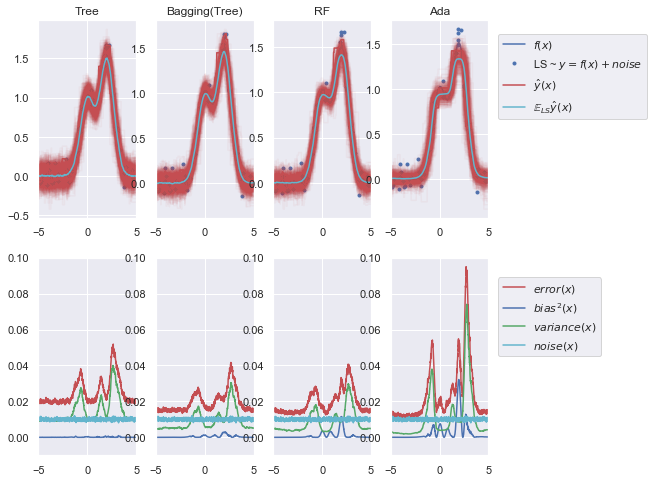

In [110]:
# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 200       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(1)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()),
               ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor())),
               ("RF", RandomForestRegressor(max_depth=5)),
             ("Ada",AdaBoostRegressor())]

n_estimators = len(estimators)


# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label=r"$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([-.01, 0.1])

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()